In [ ]:
!pip install transformers -q
!pip install pytorch_metric_learning -q
!pip install faiss-gpu -q

     |████████████████████████████████| 3.8 MB 28.3 MB/s 
     |████████████████████████████████| 895 kB 48.1 MB/s 
     |████████████████████████████████| 67 kB 4.9 MB/s 
     |████████████████████████████████| 596 kB 52.5 MB/s 
     |████████████████████████████████| 6.5 MB 51.1 MB/s 
     |████████████████████████████████| 109 kB 30.8 MB/s 
     |████████████████████████████████| 85.5 MB 99 kB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pytorch_metric_learning import samplers, losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from pytorch_metric_learning.utils.inference import MatchFinder, InferenceModel
from pytorch_metric_learning.utils import common_functions as c_f 
from pytorch_metric_learning.distances import CosineSimilarity
from transformers import DistilBertModel, DistilBertTokenizer
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls gdrive/MyDrive/VTB_task/

 test_data.csv		    train_data.csv	        weights.pth
 test_vtb_leonenkov.ipynb   weights_lr3e-4_mapatr.pth  'Тестовое задание.pdf'


In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/VTB_task/train_data.csv")
df.shape

(20952, 3)

In [ ]:
df_test = pd.read_csv("/content/gdrive/MyDrive/VTB_task/test_data.csv")
df_test.shape

(13494, 2)

In [ ]:
df.head()

,posting_id,title,label_group
0,train_129225211,Paper Bag Victoria Secret,249114794
1,train_2278313361,PAPER BAG VICTORIA SECRET,249114794
2,train_2288590299,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_3803689425,Maling Ham Pork Luncheon Meat TTS 397gr,2395904891
4,train_2406599165,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188


In [ ]:
df_test.head()

,posting_id,title
0,train_129225211,Paper Bag Victoria Secret
1,train_2278313361,PAPER BAG VICTORIA SECRET
2,train_3386243561,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO..."
3,train_3423213080,Double Tape VHB 3M ORIGINAL 12mm x 4.5mm Busa ...
4,train_2288590299,Maling TTS Canned Pork Luncheon Meat 397 gr


In [ ]:
df.label_group.unique().shape

(6608,)

In [ ]:
tmp = df.groupby(['label_group'])['posting_id'].unique().to_dict()
df['matches'] = df['label_group'].map(tmp)
df['matches'] = df['matches'].apply(lambda x: ' '.join(x))

нашей метрикой будет построчный f1

In [ ]:
def f1_score(y_true, y_pred):
    y_true = y_true.apply(lambda x: set(x.split()))
    y_pred = y_pred.apply(lambda x: set(x.split()))
    intersection = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    len_y_pred = y_pred.apply(lambda x: len(x)).values
    len_y_true = y_true.apply(lambda x: len(x)).values
    f1 = 2 * intersection / (len_y_pred + len_y_true)
    return f1

в качестве бейзлайна сопоставим себя в группу только с самим собой и каким нибудь еще одним случайным товаром

In [ ]:
df['prediction'] = df['posting_id'] + ' ' + 'train_129225211'

In [ ]:
df[100:105]

,posting_id,title,label_group,matches,prediction
100,train_2588696693,(ORIGINAL 10000%) TZUKI SOAP FULL SIZE,3489985175,train_1734882388 train_3043787667 train_285618...,train_2588696693 train_129225211
101,train_1647008554,TZUKI SOAP,3489985175,train_1734882388 train_3043787667 train_285618...,train_1647008554 train_129225211
102,train_3783601581,SABUN PEMUTIH TZUKI ORIGINAL PENGHILANG JERAWA...,3489985175,train_1734882388 train_3043787667 train_285618...,train_3783601581 train_129225211
103,train_1764388603,Sabun Tzuki Ori dijamin asli 100%,3489985175,train_1734882388 train_3043787667 train_285618...,train_1764388603 train_129225211
104,train_3653012320,Sabun TZUKI TSUKI SUKI Collagen Original 100% ...,3489985175,train_1734882388 train_3043787667 train_285618...,train_3653012320 train_129225211


In [ ]:
from collections import Counter

In [ ]:
max(Counter(df.label_group).values())

51

In [ ]:
min(Counter(df.label_group).values())

2

In [ ]:
f1_score(df.matches, df.prediction).mean()

0.35675992543848534

твоя цель улучшить эту метрику, можешь пользоваться любыми методами

но учитывай что на проде данных много и методы должны адаптироваться на большие данные

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.25, random_state=77)

In [ ]:
def read_data(df, mode=None):

    data = {"posting_id": [], "title": [], "label_group": [], "matches": []}
    data["posting_id"] = df['posting_id'].tolist()
    df['title'] = df['title'].map(str.lower) #переведем в нижний регистр
    data["title"] = df['title'].tolist()

    if mode=='train':
        data["label_group"] = df['label_group'].tolist()
        data["matches"] = df['matches'].tolist()

    return data

In [ ]:
tr_data = read_data(train_df, 'train')
val_data = read_data(val_df, 'train')
test_data = read_data(df_test)

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Посмотрим на самую длинную строку title для выбора оптимального параметра max_length в dataloader 

In [ ]:
def title_len(title):
    title = title.apply(lambda x: list(tokenizer.tokenize(x)))
    title_len = title.map(len)
    return title_len, np.argmax(title_len), title_len.sort_values().max()

train_title_len, num_max_tr_title_len, max_tr_title_len = title_len(df["title"])
test_title_len, num_max_test_title_len, max_test_title_len = title_len(df_test["title"])

print(f'Самая длинная строка в трейнсете (номер, длина): {(num_max_tr_title_len, max_tr_title_len)}\nСамая длинная строка тестсета (номер, длина): {(num_max_test_title_len, max_test_title_len)}')

Самая длинная строка в трейнсете (номер, длина): (2212, 261)
Самая длинная строка тестсета (номер, длина): (1139, 261)


In [ ]:
train_title_len.value_counts().sort_index(ascending=False).head(50)

261     1
175     1
123     2
120     1
118     1
113     1
111     2
110     1
104     1
103     1
102     1
101     1
98      1
95      1
94      1
92      2
88      1
87      1
85      2
84      2
83      2
80      1
77      3
76      1
75      3
74      2
73      4
72      1
71      4
70      3
69      7
68      5
67      5
66      3
65      4
64      2
63      6
62      3
61      3
60      6
59      8
58      6
57      7
56      6
55     11
54     12
53      6
52     20
51     11
50     20
Name: title, dtype: int64

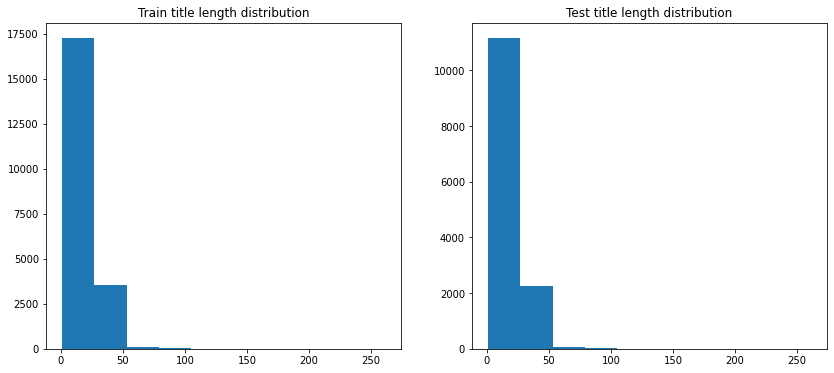

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].hist(train_title_len)
axs[0].set_title('Train title length distribution')
axs[1].hist(test_title_len)
axs[1].set_title('Test title length distribution')

plt.show()

Посмотрим на модель

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
class GoodsDataset(Dataset):
    def __init__(self, data, tokenizer=tokenizer, max_length=263): #263 из-за [CLS] и [SEP]
        self.title = data['title']
        self.labels = data['label_group']
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __getitem__(self, idx):
        tokenizer_output = self.tokenizer.encode_plus(
                            self.title[idx],
                            None,
                            add_special_tokens=True,
                            max_length=self.max_length,
                            padding='max_length',
        )

        return {
            "input_ids": torch.tensor(tokenizer_output['input_ids'], dtype=torch.long).squeeze(0),
            "attention_mask": torch.tensor(tokenizer_output['attention_mask'], dtype=torch.long).squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long).squeeze(0) 
        }

    def __len__(self):
        return len(self.title)

tr_dataset = GoodsDataset(tr_data)
val_dataset = GoodsDataset(val_data)

In [ ]:
class DatasetForTest(GoodsDataset):
    def __getitem__(self, idx):
        tokenizer_output = self.tokenizer.encode_plus(
                            self.title[idx],
                            None,
                            add_special_tokens=True,
                            max_length=self.max_length,
                            padding='max_length',
        )

        return torch.tensor(tokenizer_output['input_ids'], dtype=torch.long).squeeze(0),\
               self.labels[idx]#torch.tensor(self.labels[idx], dtype=torch.long).squeeze(0) #


# tr_test_dataset = DatasetForTest(tr_data)
# val_test_dataset = DatasetForTest(val_data)

In [ ]:
sampler = samplers.MPerClassSampler(tr_dataset.labels, m=4, length_before_new_iter=len(tr_dataset))
tr_dataloader = DataLoader(tr_dataset, batch_size=64, sampler=sampler)
val_dataloader = DataLoader(val_dataset, batch_size=64)

train_dataloader = DataLoader(tr_dataset, batch_size=64) # withou

Выбираем метрику, лосс, трешолд лосса и майнер

Примеры кода смотрел тут https://github.com/KevinMusgrave/pytorch-metric-learning/blob/master/examples/README.md

In [ ]:
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0)
loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer) 
mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")
accuracy_calculator = AccuracyCalculator(include = ("precision_at_1",), k = 1)

In [ ]:
def train(model, loss_func, mining_func, device, tr_dataloader, optimizer, epoch):
    model.train()
    for idx, train_batch in enumerate(tr_dataloader):

        input_ids = train_batch['input_ids'].to(device)
        attention_mask = train_batch['attention_mask'].to(device)
        labels = train_batch['labels'].to(device)

        optimizer.zero_grad()
        embeddings = model.forward(input_ids, attention_mask).last_hidden_state[:, 0, :]
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if idx % 20 == 0:
            print("Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(epoch, idx, loss, mining_func.num_triplets))

Валидация и расчёт Accuracy

In [ ]:
# def get_all_embeddings(dataset, model):
#     tester = testers.BaseTester(use_trunk_output=True)
#     return tester.get_all_embeddings(dataset, model)

In [ ]:
# def test(train_set, test_set, model, accuracy_calculator):
#     train_embeddings, train_labels = get_all_embeddings(train_set, model)
#     test_embeddings, test_labels = get_all_embeddings(test_set, model)
#     #print(train_embeddings.shape, train_labels.shape)
#     train_labels = train_labels.squeeze(1)
#     test_labels = test_labels.squeeze(1)
#     print("Computing accuracy")
#     accuracies = accuracy_calculator.get_accuracy(test_embeddings, 
#                                                   train_embeddings,
#                                                   test_labels,
#                                                   train_labels,
#                                                   False)
#     print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))

In [ ]:
def get_all_embeddings(dataloader, model, device):
    with torch.no_grad():
        for idx, batch in enumerate(tqdm.tqdm(dataloader)):
            
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            mask = batch['attention_mask'].to(device)
            output = model.forward(inputs, mask).last_hidden_state[:, 0, :]

            if idx==0:
                embeddings = output
                targets = labels
            else:
                embeddings = torch.cat((embeddings, output), 0)
                targets = torch.cat((targets, labels), 0)
    return embeddings, targets

In [ ]:
def eval(tr_dataloader, val_dataloader, model, device, accuracy_calculator):
    model.eval()
    tr_embeddings, tr_labels = get_all_embeddings(tr_dataloader, model, device)
    val_embeddings, val_labels = get_all_embeddings(val_dataloader, model, device)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(val_embeddings, 
                                                  tr_embeddings,
                                                  val_labels,
                                                  tr_labels,
                                                  False)
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 4

In [ ]:
for epoch in range(1, num_epochs+1):
    train(model, loss_func, mining_func, device, tr_dataloader, optimizer, epoch)
    #test(tr_test_dataset, val_test_dataset, model, accuracy_calculator)
    eval(tr_dataloader, val_dataloader, model, device, accuracy_calculator)

Epoch 1 Iteration 0: Loss = 0.07962851226329803, Number of mined triplets = 33
Epoch 1 Iteration 20: Loss = 0.08239924162626266, Number of mined triplets = 231
Epoch 1 Iteration 40: Loss = 0.06562807410955429, Number of mined triplets = 141
Epoch 1 Iteration 60: Loss = 0.06933343410491943, Number of mined triplets = 401
Epoch 1 Iteration 80: Loss = 0.07990532368421555, Number of mined triplets = 313
Epoch 1 Iteration 100: Loss = 0.05330533906817436, Number of mined triplets = 116
Epoch 1 Iteration 120: Loss = 0.047804027795791626, Number of mined triplets = 27
Epoch 1 Iteration 140: Loss = 0.06640966981649399, Number of mined triplets = 129
Epoch 1 Iteration 160: Loss = 0.06907375901937485, Number of mined triplets = 116
Epoch 1 Iteration 180: Loss = 0.08765216916799545, Number of mined triplets = 175
Epoch 1 Iteration 200: Loss = 0.06681731343269348, Number of mined triplets = 190
Epoch 1 Iteration 220: Loss = 0.0781012773513794, Number of mined triplets = 326
Epoch 1 Iteration 240: L

100%|██████████| 82/82 [00:54<00:00,  1.51it/s]


Computing accuracy
Test set accuracy (mAP@r) = 0.48395324157129804
Epoch 2 Iteration 0: Loss = 0.04140348359942436, Number of mined triplets = 63
Epoch 2 Iteration 20: Loss = 0.021268080919981003, Number of mined triplets = 35
Epoch 2 Iteration 40: Loss = 0.04352694749832153, Number of mined triplets = 80
Epoch 2 Iteration 60: Loss = 0.06920381635427475, Number of mined triplets = 118
Epoch 2 Iteration 80: Loss = 0.04039594531059265, Number of mined triplets = 60
Epoch 2 Iteration 100: Loss = 0.0796680673956871, Number of mined triplets = 328
Epoch 2 Iteration 120: Loss = 0.07888764888048172, Number of mined triplets = 156
Epoch 2 Iteration 140: Loss = 0.08278390020132065, Number of mined triplets = 265
Epoch 2 Iteration 160: Loss = 0.06724340468645096, Number of mined triplets = 185
Epoch 2 Iteration 180: Loss = 0.07664871215820312, Number of mined triplets = 95
Epoch 2 Iteration 200: Loss = 0.057897064834833145, Number of mined triplets = 68
Epoch 2 Iteration 220: Loss = 0.0628960281

100%|██████████| 82/82 [00:54<00:00,  1.51it/s]


Computing accuracy
Test set accuracy (mAP@r) = 0.4960343134492145
Epoch 3 Iteration 0: Loss = 0.07463882863521576, Number of mined triplets = 205
Epoch 3 Iteration 20: Loss = 0.055391423404216766, Number of mined triplets = 33
Epoch 3 Iteration 40: Loss = 0.04109225422143936, Number of mined triplets = 28
Epoch 3 Iteration 60: Loss = 0.0812782421708107, Number of mined triplets = 301
Epoch 3 Iteration 80: Loss = 0.05994256213307381, Number of mined triplets = 119
Epoch 3 Iteration 100: Loss = 0.0632646456360817, Number of mined triplets = 61
Epoch 3 Iteration 120: Loss = 0.0772828683257103, Number of mined triplets = 46
Epoch 3 Iteration 140: Loss = 0.05548376962542534, Number of mined triplets = 207
Epoch 3 Iteration 160: Loss = 0.009610459208488464, Number of mined triplets = 2
Epoch 3 Iteration 180: Loss = 0.07256975769996643, Number of mined triplets = 142
Epoch 3 Iteration 200: Loss = 0.07922320067882538, Number of mined triplets = 39
Epoch 3 Iteration 220: Loss = 0.07807779312133

100%|██████████| 82/82 [00:54<00:00,  1.51it/s]


Computing accuracy
Test set accuracy (mAP@r) = 0.5112263388010346
Epoch 4 Iteration 0: Loss = 0.03350929170846939, Number of mined triplets = 3
Epoch 4 Iteration 20: Loss = 0.09903416037559509, Number of mined triplets = 357
Epoch 4 Iteration 40: Loss = 0.05191576108336449, Number of mined triplets = 87
Epoch 4 Iteration 60: Loss = 0.04428199306130409, Number of mined triplets = 58
Epoch 4 Iteration 80: Loss = 0.12179192900657654, Number of mined triplets = 146
Epoch 4 Iteration 100: Loss = 0.06572090834379196, Number of mined triplets = 68
Epoch 4 Iteration 120: Loss = 0.07968156784772873, Number of mined triplets = 106
Epoch 4 Iteration 140: Loss = 0.05454923212528229, Number of mined triplets = 18
Epoch 4 Iteration 160: Loss = 0.0649171769618988, Number of mined triplets = 86
Epoch 4 Iteration 180: Loss = 0.051491737365722656, Number of mined triplets = 12
Epoch 4 Iteration 200: Loss = 0.06619733572006226, Number of mined triplets = 58
Epoch 4 Iteration 220: Loss = 0.066070660948753

100%|██████████| 82/82 [00:54<00:00,  1.52it/s]


Computing accuracy
Test set accuracy (mAP@r) = 0.49794622885700757


In [ ]:
model

Identity()

In [ ]:
torch.save(model.state_dict(), "/content/gdrive/MyDrive/VTB_task/weights.pth")

In [ ]:
dataset = DatasetForTest(read_data(df, 'train'))

labels_to_indices = c_f.get_labels_to_indices(dataset.labels)

In [ ]:
class1 = labels_to_indices[0]

In [ ]:
dataset[0]

(tensor([ 101, 3259, 4524, 3848, 3595,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,  

In [ ]:
# model = c_f.Identity()
match_finder = MatchFinder(distance=CosineSimilarity(), threshold=0.95)
inference_model = InferenceModel(model, match_finder=match_finder)
inference_model.train_indexer(dataset.)

RuntimeError: ignored